In [24]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(patchwork)
library(scales)
library(RColorBrewer)


# Read color hex code for cell types

In [25]:
color_annotation<-read.csv('/home//workspace/IHA_Figure_Revision/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read deseq2 result

In [26]:
deseq2_result_Y1D0<-read.csv('02_DEG//Deseq2_Result_Y1D0.csv')

# Count degs for age group

In [38]:
deg_counts_df <- deseq2_result_Y1D0 %>%
  filter(contrast == 'cohort.cohortGuid') %>%
  mutate(Expression = case_when(
    log2FoldChange >= 0.1 & padj <= 0.05 ~ "Up-regulated",
    log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
    TRUE ~ "Unchanged"
  )) %>%
  group_by(celltype, Expression) %>%
  summarise(count = n(), .groups = 'drop') %>%
  complete(celltype, Expression, fill = list(count = 0)) %>% 
  filter(!Expression=="Unchanged")%>%  as.data.frame()%>%
  mutate(count = case_when(
    Expression == "Down-regulated" ~ -count,
    TRUE ~ count
  ))

# Count total genes tested

In [39]:
total_counts_df<-table(deseq2_result_Y1D0 %>% 
                       filter(contrast=='cohort.cohortGuid')%>% 
                       select(celltype)) %>% as.data.frame()

# Barplot

### total gene tested 

In [40]:
total_counts_df$celltype<-factor(total_counts_df$celltype,levels=color_annotation$label)

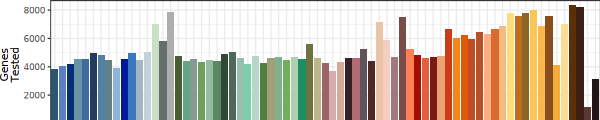

In [41]:
options(repr.plot.width = 5, repr.plot.height = 1)

p1<-ggplot(total_counts_df, aes(x=celltype, y=Freq, fill = celltype)) +
  geom_bar(stat="identity",width=0.8)+theme_bw(base_size=6)+
theme(legend.position="none")+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+ 
scale_fill_manual(values=color_vector)+ylab('Genes\nTested')+
theme(plot.margin=grid::unit(c(0,0,-2.5,0), "mm"))
p1

In [42]:
colnames(total_counts_df)[2]<-"Genes_Tested"
write.csv(total_counts_df %>% select(celltype,Genes_Tested),
          "/home//workspace/Source_Data/Fig1e_1.csv", row.names=FALSE) 

### deg number

In [43]:
deg_counts_df$celltype<-factor(deg_counts_df$celltype,levels=color_annotation$label)

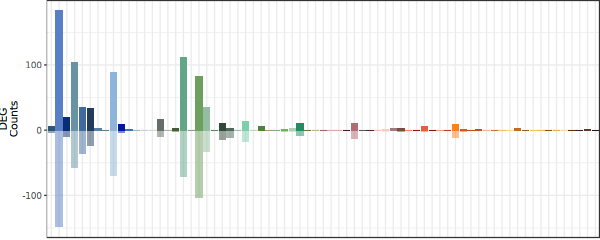

In [44]:
options(repr.plot.width = 5, repr.plot.height = 2)

p2<-ggplot(deg_counts_df, aes(x = celltype, y = count, fill = celltype)) +
  geom_bar(stat = "identity",width=0.8,aes(alpha=Expression) ) + 
scale_fill_manual(values=color_vector)+
labs(y = "DEG\nCounts", x = "Cell Type") +
  scale_alpha_manual(values = c(0.5, 1)) +
  theme_bw(base_size=6)+
theme(legend.position="none")+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
theme(plot.margin=grid::unit(c(0,0,0,-.25), "mm"))+
scale_x_discrete(labels = function(x) gsub(" cell", "", x))+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
p2

In [46]:
write.csv(deg_counts_df %>% select(celltype,count,Expression),
          "/home//workspace/Source_Data/Fig1e_2.csv", row.names=FALSE) 

In [47]:
max_deg_number<-deg_counts_df %>% group_by(celltype) %>% 
mutate(count=abs(count)) %>% summarise(total_count=sum(count)) %>% arrange(desc(total_count) )

In [48]:
max_deg_number<-pull(max_deg_number[1,2])

In [49]:
max_deg_number

[1] 331

# Heatmap for other comparison

In [50]:
Y1D0<-read.csv("05-DEG_Vax_and_NoVax/Deseq2_Result_Y1D0.csv")
Y1D0<-Y1D0 %>% mutate(contrast=case_when(contrast=="cohort.cohortGuid"~"Age Group",
                                         contrast=="subject.biologicalSex"~"Sex",
                                         contrast=="CMV"~"CMV",
                                         TRUE~NA))

Y1D0_Y1D7<-read.csv("05-DEG_Vax_and_NoVax/Deseq2_Result_Y1D0_Y1D7.csv")
Y1D0_Y1D7$contrast<-"Flu Vax"

NoVaxD0_NoVaxD7<-read.csv("05-DEG_Vax_and_NoVax/Deseq2_Result_NoVaxD0_NoVaxD7.csv")
NoVaxD0_NoVaxD7$contrast<-"No Vax"

df<-do.call(rbind,list(Y1D0,Y1D0_Y1D7,NoVaxD0_NoVaxD7))

In [51]:
deg_counts_df <- df %>%
  mutate(Expression = case_when(
    log2FoldChange >= 0.1 & padj <= 0.05 ~ "Up-regulated",
    log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
    TRUE ~ "Unchanged"
  )) %>%
  group_by(celltype, contrast,Expression) %>%
  summarise(count = n(), .groups = 'drop') %>%
  complete(celltype, contrast,Expression, fill = list(count = 0)) %>% 
  filter(!Expression=="Unchanged")%>%  as.data.frame()%>%
  mutate(count = case_when(
    Expression == "Down-regulated" ~ -count,
    TRUE ~ count
  ))

In [52]:
deg_counts_df<-deg_counts_df %>% filter(!contrast=="Age Group")

In [53]:
deg_counts_df_total<-deg_counts_df %>% group_by(contrast,celltype) %>% 
mutate(count=abs(count)) %>% summarise(total_count=sum(count))

`summarise()` has grouped output by 'contrast'. You can override using the
`.groups` argument.


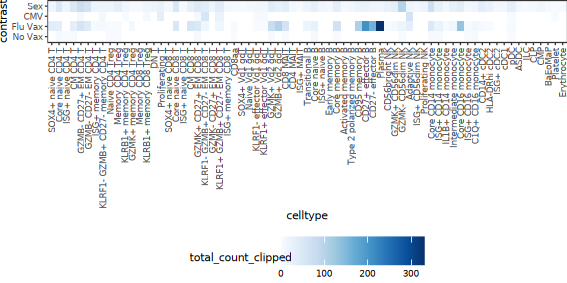

In [54]:
options(repr.plot.width = 120/25.4, repr.plot.height = 60/25.4)

deg_counts_df_total <- deg_counts_df_total %>%
  mutate(total_count_clipped = pmin(total_count, max_deg_number))
deg_counts_df_total$contrast<-factor(deg_counts_df_total$contrast,level=rev(c('Sex','CMV','Flu Vax','No Vax')))
deg_counts_df_total$celltype<-factor(deg_counts_df_total$celltype,levels=color_annotation$label)
p3 <- ggplot(deg_counts_df_total, aes(celltype, contrast, fill = total_count_clipped)) + 
  geom_tile() +
  theme_bw(base_size = 6) +
  theme(legend.position = "bottom") + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  theme(plot.margin = grid::unit(c(0, 0, 0, -0.25), "mm")) +
  scale_x_discrete(labels = function(x) gsub(" cell", "", x)) +

  scale_fill_gradientn(
    colours = c("white", brewer.pal(9, "Blues")[0:9]),
    values = rescale(c(0, seq(1, max_deg_number, length.out = 9))),
    limits = c(0, max_deg_number)
  )
                   
                   p3

In [56]:
write.csv(deg_counts_df_total %>% select(celltype,contrast,total_count_clipped),
          "/home//workspace/Source_Data/Fig1e_3.csv", row.names=FALSE) 

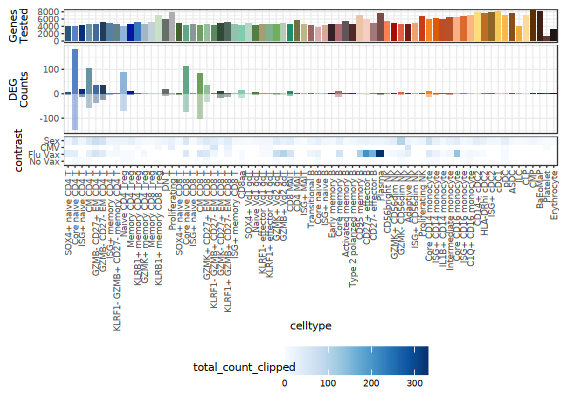

In [57]:
options(repr.plot.width = 120/25.4, repr.plot.height = 85/25.4)
combined_plot <- p1 / p2 / p3 + plot_layout(heights = c(1.5,4,1.3))
combined_plot
ggsave(filename = "FigureE.pdf", plot = combined_plot, width = 120/25.4, height = 85/25.4)

In [58]:
deg_counts_df

celltype,contrast,Expression,count
<chr>,<chr>,<chr>,<int>
ASDC,CMV,Down-regulated,0
ASDC,CMV,Up-regulated,0
ASDC,Flu Vax,Down-regulated,0
ASDC,Flu Vax,Up-regulated,0
ASDC,No Vax,Down-regulated,0
ASDC,No Vax,Up-regulated,0
ASDC,Sex,Down-regulated,-3
ASDC,Sex,Up-regulated,6
Activated memory B cell,CMV,Down-regulated,0
